In [1]:
# Import libraries
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Read data 
file_path = 'E-commerce_data.xlsx' 
customers = pd.read_excel(file_path, sheet_name='customers')
genders = pd.read_excel(file_path, sheet_name='genders')
cities = pd.read_excel(file_path, sheet_name='cities')
transactions = pd.read_excel(file_path, sheet_name='transactions')
branches = pd.read_excel(file_path, sheet_name='branches')
merchants = pd.read_excel(file_path, sheet_name='merchants')

In [4]:
# Step 1: Merge transactions with customers
merged_data = pd.merge(transactions, customers, on='customer_id', how='left')

In [5]:
# Step 2: Merge with branches
merged_data = pd.merge(merged_data, branches, on='branch_id', how='left')

In [6]:
# Step 3: Merge with merchants
merged_data = pd.merge(merged_data, merchants, on='merchant_id', how='left')

In [7]:
# Step 4: Merge with genders
merged_data = pd.merge(merged_data, genders, on='gender_id', how='left')

In [8]:
# Step 5: Merge with cities
merged_data = pd.merge(merged_data, cities, on='city_id', how='left')

In [9]:
merged_data

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_id,gender_id,merchant_id,merchant_name,gender_name,city_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,2023-05-16,15,2,7,Berry-Anderson,Female,Aswan
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,14,2,9,"Campbell, Shaffer and Martinez",Female,Damietta
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2022-05-30,2,1,7,Berry-Anderson,Male,Alexandria
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,2023-11-27,15,2,18,Lewis LLC,Female,Aswan
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,14,1,15,Butler-Gomez,Male,Damietta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,776,2024-03-20,subscribed,OSq-518,NaT,1,2022-01-08,12,1,11,"Smith, Lawson and Hernandez",Male,Fayyum
4996,4997,583,2024-06-27,subscribed,FsJ-607,NaT,2,2023-08-03,5,2,18,Lewis LLC,Female,Port Said
4997,4998,504,2022-11-08,burned,WcY-330,2022-12-06,2,2022-03-12,10,2,18,Lewis LLC,Female,Asyut
4998,4999,876,2024-05-05,burned,bgx-731,2024-07-29,7,2022-11-19,5,2,7,Berry-Anderson,Female,Port Said


In [10]:
# Feature Engineering: Create relevant features for segmentation

# 1. Coupon usage frequency (number of transactions per customer)
coupon_usage = merged_data.groupby('customer_id')['transaction_id'].count().reset_index()
coupon_usage.columns = ['customer_id', 'coupon_usage_frequency']

coupon_usage

,customer_id,coupon_usage_frequency
0,1,7
1,2,3
2,3,5
3,4,1
4,5,4
...,...,...
984,996,3
985,997,3
986,998,4
987,999,4


In [11]:
# 2. Transaction status (number of 'burned' transactions per customer)
burned_transactions = merged_data[merged_data['transaction_status'] == 'burned'].groupby('customer_id')['transaction_id'].count().reset_index()
burned_transactions.columns = ['customer_id', 'burned_count']

burned_transactions

,customer_id,burned_count
0,1,3
1,2,1
2,3,1
3,5,3
4,6,4
...,...,...
904,995,2
905,997,1
906,998,3
907,999,4


In [12]:
# 3. Merge the coupon usage and burned transactions data back into the main dataset
segmentation_data = pd.merge(coupon_usage, burned_transactions, on='customer_id', how='left')

segmentation_data

,customer_id,coupon_usage_frequency,burned_count
0,1,7,3.0
1,2,3,1.0
2,3,5,1.0
3,4,1,NaN
4,5,4,3.0
...,...,...,...
984,996,3,NaN
985,997,3,1.0
986,998,4,3.0
987,999,4,4.0


In [13]:
# Fill missing values for 'burned_count' with 0 (customers who never burned a coupon)
segmentation_data['burned_count'] = segmentation_data['burned_count'].fillna(0)

In [14]:
# Add gender and city data
segmentation_data = pd.merge(segmentation_data, merged_data[['customer_id', 'gender_name', 'city_name']].drop_duplicates(), on='customer_id', how='left')

In [15]:
# Select features for clustering
X = segmentation_data[['coupon_usage_frequency', 'burned_count']]

In [16]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
inertia = []

# Test different values of K (from 1 to 10 or more)
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # Use scaled data for clustering
    inertia.append(kmeans.inertia_)  # Inertia: Sum of squared distances

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

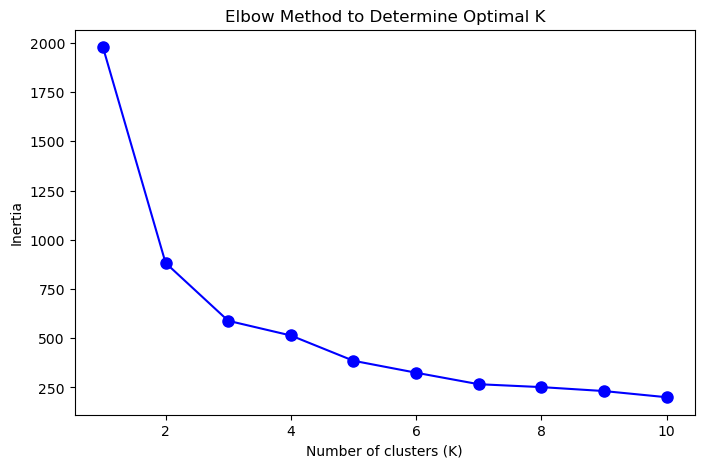

In [25]:
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()

In [20]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
segmentation_data['cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [21]:
# Evaluate using silhouette score
silhouette_avg = silhouette_score(X_scaled, segmentation_data['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.4023587853408439


In [22]:
# Display the cluster assignment
segmentation_data.head()

,customer_id,coupon_usage_frequency,burned_count,gender_name,city_name,cluster
0,1,7,3.0,Male,Mansoura,2
1,2,3,1.0,Female,Sohag,1
2,3,5,1.0,Male,Aswan,4
3,4,1,0.0,Female,Ismailia,1
4,5,4,3.0,Male,El-Mahalla El-Kubra,4


In [23]:
# Analyze customer segments
segment_analysis = segmentation_data.groupby('cluster').agg({
    'coupon_usage_frequency': 'mean',
    'burned_count': 'mean',
    'gender_name': lambda x: x.mode()[0],  # Most common gender
    'city_name': lambda x: x.mode()[0]     # Most common city
}).reset_index()

segment_analysis

,cluster,coupon_usage_frequency,burned_count,gender_name,city_name
0,0,9.120000,5.693333,Male,Alexandria
1,1,2.551237,0.978799,Male,Damanhur
2,2,7.952000,3.032000,Male,Ismailia
3,3,5.911765,4.279412,Female,Aswan
4,4,4.854054,2.300000,Female,Cairo
